# Scripts to analyze the study data

(Q1) TIMING PER PARTICIPANT (SQL vs RD)
1. Per participant, calculate the median time in seconds spent on SQL and RD (32/2=16 per mode and participant, irrespective of correctness)
2. Q1a: show violin plot figure with median times per user compared via gray lines
3. Calculate their ratio per user (also gives fraction of users who are faster with one or the other)
4. Calculate the median of those fractions and the 95% CI
5. Q1b: show violin plot figure with fractions, and also 95% CI

(Q2) TIMING PER PARTICIPANT (SQL vs RD / 1st vs. 2nd half)
1. Per participant, calculate the median time over all questions answered in 1st half in RD (32/2/2=8) and SQL, and in 2nd half.
2. Q2: show repeated measure violin plot figure, showing improvements over time, of 2 halfs
3. Calculate the relative ratio for timing 2nd/1st for RD, and SQL including 95% CI

(Q3) TIMING PATTERNS ACROSS PARTICIPANTS
1. calculate the median time per pattern (4) across the two modes (2). Thus 8 values.
2. show repeated measure violin plot figure

(Q4) CORRECTNESS (SQL vs RD)
1. take mean correct over all questions and all users answered in SQL (32/2*13), or in RD (2 values)
2. calculate 95% CI for each, and sampled p-value (perhaps with difference?)

## Load packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid",font_scale=2)
import matplotlib.pyplot as plt
from scipy.stats import bootstrap as scipybootstrap
from IPython.display import display

# Tell matplotlib to export svg text as text not paths
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.axisbelow'] = True   # draw axes and grids behind everything else

# Set Jupyter and Pandas to show 3 decimal places, does not work for lists of numbers
%precision 3
pd.options.display.float_format = '{:,.3f}'.format
np.set_printoptions(precision=3)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})            # TODO: does not work for lists
def print(*args):
    __builtins__.print(*("%.3f" % a if isinstance(a, float) else a
                         for a in args))

## Global Variables Setup

In [2]:
# A set of constant global variables used throughout the notebook
num_questions = 32
modes = ['SQL', 'RD']
mode_to_name = {0: 'SQL', 1: 'RD'}

BOOTSTRAPCONFIDENCE = 0.95      # confidence level used for bootstrap
BOOTSTRAPMETHOD = 'BCa'         # method used for bootstrap, appears to be better than the textbook version for mean (but not for median), also available as 'percentage'
BOOTSTRAPSAMPLES = 10000        # number of resamples
filename = 'data/anonymized_data.csv'   # file with appropriately transformed data ready for analysis
TRANSFORMDATA = False            # used only once to transform the original data

## Define subfolder where figures are stored

By default, figures will not be saved. If you want to save figures, set savefig to `True`.
Learned from: https://github.com/jorvlan/open-visualizations/blob/master/Python/tutorial_2/repeated_measures_python_2.ipynb

In [3]:
savefig = True
if savefig:
    import os
    from os.path import isdir
    cwd = os.getcwd()   # Get current working directory, but you can specify your own directory of course.
    if  os.path.exists(cwd + "/figs"):
        print("Directory already exists")
        fig_dir = cwd + "/figs"     # Assign the existing directory to a variable
    elif not os.path.exists(cwd + "/figs"):
        print("Directory does not exist and will be created ......")
        os.makedirs(cwd + "/figs")
        if isdir(cwd + "/figs"):
            print('Directory was created succesfully')
        fig_dir = cwd + "/figs"     # Assign the created directory to a variable
    else:
        print("Something went wrong")

Directory already exists


## Loading original data, transforming it, and saving it anonymized

Loading the original data, anonymizing it, transforming it to make available for later analysis and saving it


In [4]:
if TRANSFORMDATA:
    ANONYMIZE = False

    # --- Load original study data TODO: This should point to our full study data when it is available
    studyfilename = 'data/users-table-pilot.csv'
    encodingfilename = 'data/worker_ids.csv'
    df = pd.read_csv(studyfilename)

    # --- Turn string to array
    from ast import literal_eval            # to turn string to array
    df['pattern_order']= df['pattern_order'].apply(literal_eval)
    display(df)

    # --- Anonymize the workers with randomized categories (https://pandas.pydata.org/docs/user_guide/categorical.html#working-with-categories)
    if ANONYMIZE:
        c = df.worker_id.astype('category')
        d = dict(enumerate(c.cat.categories))

        from random import shuffle
        keys = list(d.keys())
        shuffle(keys)
        d = dict(zip(d.values(), keys))             # randomize the category assignment s.t. categorical numbers are identical with alphabetical order

        with open(encodingfilename, 'w') as f:      # save the category encoding
            for key in d.keys():
                f.write("%s,%s\n"%(key,d[key]))

        df["worker_id"] = df["worker_id"].map(d)    # replace worker_ids with randomized categories

    # display(df)
    # The "current page" is the section of the study the workers are doing to save their state & prevent them cheating

    # --- The following code block transforms the data frame to have one question per row. That simplifies the later analysis.
    # reshape df (melt, pivot) to bring multiple question times (e.g. 'q7_time') per row into separate rows
    # https://towardsdatascience.com/wide-to-long-data-how-and-when-to-use-pandas-melt-stack-and-wide-to-long-7c1e0f462a98
    df2 = df.melt(id_vars=['worker_id', 'sequence_num', 'pattern_order',
                           'q1', 'q2','q3', 'q4','q5', 'q6','q7', 'q8', 'q9', 'q10',
                           'q11', 'q12','q13', 'q14','q15', 'q16','q17', 'q18', 'q19', 'q20',
                           'q21', 'q22','q23', 'q24','q25', 'q26','q27', 'q28', 'q29', 'q30',
                           'q31', 'q32'], value_vars=['q1_time', 'q2_time', 'q3_time', 'q4_time','q5_time', 'q6_time', 'q7_time', 'q8_time', 'q9_time', 'q10_time',
                                                      'q11_time', 'q12_time', 'q13_time', 'q14_time', 'q15_time', 'q16_time', 'q17_time', 'q18_time', 'q19_time', 'q20_time',
                                                      'q21_time', 'q22_time', 'q23_time', 'q24_time', 'q25_time', 'q26_time', 'q27_time', 'q28_time', 'q29_time', 'q30_time',
                                                      'q31_time', 'q32_time'], var_name='question', value_name='time')

    # replace time in msec with sec in column 'time'
    df2['time'] = df2['time'] / 1000

    # replace question string 'q7_time' with number '7' in column 'question'
    from re import search as re_search               # regular expression
    new_column = []
    for values in df2['question']:
        new_column.append(int(re_search(r'\d+', values).group()))
    df2['question'] = new_column

    # choose the right pattern from the list 'pattern_order' and add as column 'pattern'
    new_column = []
    for (pattern_order_list, ind) in zip(df2['pattern_order'], df2['question']):
        new_column.append(pattern_order_list[ind-1])
    df2['pattern'] = new_column

    # determine the 'mode' (SQL or RD) from 'sequence_num' and 'question'
    #   sequence_num = 0 means that the first question is shown in SQL, 1 means we start instead with RD. Then alternate between the two.
    #   Thus (sequence_num + question_num) % 2 == 1 means SQL
    #   Thus (sequence_num + question_num) % 2 == 0 means RD
    new_column = []
    for (sequence, question) in zip(df2['sequence_num'], df2['question']):
        mode = 'SQL' if (sequence + question) % 2 == 1 else 'RD'
        new_column.append(mode)
    df2['mode'] = new_column

    # determine the 'choice' (among the 4 patterns) made by the user for this question. Requires all the 32 question choices (e.g. 'q7') and index of the question at hand ('question')
    questionarray = df2[['q1', 'q2','q3', 'q4','q5', 'q6','q7', 'q8', 'q9', 'q10',
                         'q11', 'q12','q13', 'q14','q15', 'q16','q17', 'q18', 'q19', 'q20',
                         'q21', 'q22','q23', 'q24','q25', 'q26','q27', 'q28', 'q29', 'q30',
                         'q31', 'q32']].to_numpy()
    questionindex = df2[["question"]].to_numpy()

    new_array = np.take_along_axis(questionarray,questionindex-1,1)     # take the 'questionindex'-th entry from each row of the questionarray (notice 1-index vs 0-indexin)
    df2['choice'] = new_array

    # determine whether the choice was correct by comparing the ground truth ('pattern') against the choice made ('choice'). Saved as 0/1 value in new column 'correct'
    new_column = []
    for (pattern, choice) in zip(df2['pattern'], df2['choice']):
        correct = 1 if pattern == choice else 0
        new_column.append(correct)
    df2['correct'] = new_column

    # sort by worker and question number, and reset the inde
    df2.sort_values(by=['worker_id', 'question'], inplace=True)
    df2.reset_index(drop=True, inplace=True)
    # display(df2)

    # select only the relevant subset of columns
    df_anonymized_data = df2[['worker_id', 'question', 'time', 'pattern', 'mode', 'choice', 'correct']]
    # display(df3)

    # pd.write_csv(filename)
    df_anonymized_data.to_csv(filename,
                              index=False,
                              )

## Loading anonymized data

In [5]:
df_anonymized_data = pd.read_csv(filename)
display(df_anonymized_data)

,worker_id,question,time,pattern,mode,choice,correct
0,0,1,9.925,1,SQL,1,1
1,0,2,7.418,2,RD,2,1
2,0,3,14.183,4,SQL,3,0
3,0,4,4.465,4,RD,4,1
4,0,5,16.753,3,SQL,3,1
...,...,...,...,...,...,...,...
411,12,28,3.840,2,RD,2,1
412,12,29,4.081,3,SQL,2,0
413,12,30,4.327,1,RD,1,1
414,12,31,7.464,2,SQL,2,1


# Total time users took

In [6]:
dftemp = df_anonymized_data.groupby(['worker_id']).time.agg(['sum'])
dftemp['sum'] = dftemp['sum'] / 60
display(dftemp)

,sum
worker_id,
0,4.217
1,3.382
2,10.153
3,8.044
4,10.476
5,15.287
6,5.552
7,9.189
8,5.398


# Question 1. Figure 1a

In [36]:
# create two columns mode and median, with 2 rows per worker (used for Fig 1a violines)
dfq1a = df_anonymized_data.groupby(['worker_id', 'mode']).time.agg(['median'])
dfq1a.reset_index(inplace=True)
print('dfq1a:')
display(dfq1a)

# pivot to have one row per worker (used for Fig 1a individual points)
dfq1b = pd.pivot_table(dfq1a, values=['median'], index=['worker_id'], columns=['mode'])
dfq1b=dfq1b.droplevel(0, axis=1)
print('dfq1b:')
display(dfq1b)

modes = ['RD', 'SQL']
median_time = {}
ci = {}
ci_delta = {}
for mode in modes:
    median_time[mode] = np.median(dfq1b[mode])
    ci[mode] = scipybootstrap((dfq1b[mode],), statistic=np.median, n_resamples=BOOTSTRAPSAMPLES, confidence_level=BOOTSTRAPCONFIDENCE, method='percentile', axis=0).confidence_interval        #convert array to sequence
    ci_delta[mode] = [median_time[mode] - ci[mode].low, ci[mode].high - median_time[mode]]

    print(f'Median time {mode}: {median_time[mode]:.2f}, 95% CI [{ci[mode].low:.2f}, {ci[mode].high:.2f}]')

dfq1a:


,worker_id,mode,median
0,0,RD,4.433
1,0,SQL,9.242
2,1,RD,3.600
3,1,SQL,5.482
4,2,RD,10.250
5,2,SQL,21.483
6,3,RD,6.390
7,3,SQL,17.845
8,4,RD,8.292
9,4,SQL,12.992


dfq1b:


mode,RD,SQL
worker_id,,
0,4.433,9.242
1,3.600,5.482
2,10.250,21.483
3,6.390,17.845
4,8.292,12.992
5,8.787,33.992
6,4.620,6.008
7,8.368,14.653
8,6.207,10.743


Median time RD: 6.39, 95% CI [4.62, 8.37]
Median time SQL: 12.99, 95% CI [8.33, 17.84]


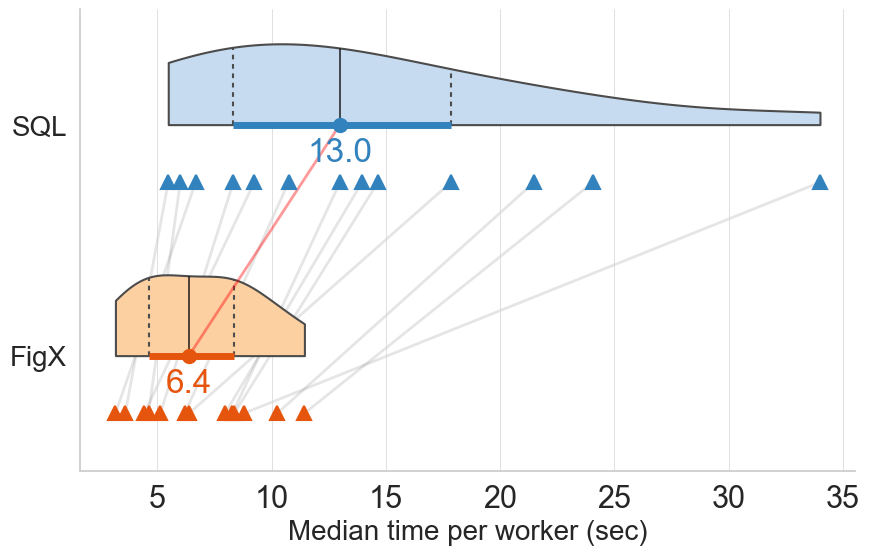

In [37]:
# Define pre-settings
figwidth = 10
figheight = 6
xlab_size = 20
ylab_size = 20
figfont_size = 24

# Define consistent color maps
my_cmap_sns_light = [(0.9921568627450981, 0.8156862745098039, 0.6352941176470588), (0.7764705882352941, 0.8588235294117647, 0.9372549019607843)]        # light blue, light orange
my_cmap_sns_dark = [(0.9019607843137255, 0.3333333333333333, 0.050980392156862744), (0.19215686274509805, 0.5098039215686274, 0.7411764705882353)]      # dark blue, dark orange
my_cmap_dark = sns.color_palette(my_cmap_sns_dark, as_cmap=True)
my_cmap_light = sns.color_palette(my_cmap_sns_light, as_cmap=True)


# Create empty figure and plot the individual datapoints
fig, ax = plt.subplots(figsize=(figwidth,figheight))


# 1. Violinplots
axsns = sns.violinplot(x='median', y='mode', data=dfq1a,
                       hue=True, hue_order=[False, True], split=True,   # half violinplots https://stackoverflow.com/questions/53872439/half-not-split-violin-plots-in-seaborn
                       inner='quartile',
                       cut=0,               # 0 means ending sharp at end points
                       width=.7,
                       orient = 'h',
                       zorder=20,)

# change the medium default line to full (https://stackoverflow.com/questions/60638344/quartiles-line-properties-in-seaborn-violinplot)
for l in axsns.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(1.2)
    l.set_color('black')
    l.set_alpha(0.8)
# for i in [0, 2, 3, 5]:         # remove the 25% and 75% quartiles
#     l = axsns.lines[i]
#     l.set_linestyle('-')
#     l.set_linewidth(0)
#     l.set_color('red')
#     l.set_alpha(0.8)

# Apply colorscheme to violinplots https://stackoverflow.com/questions/70442958/seaborn-how-to-apply-custom-color-to-each-seaborn-violinplot
from matplotlib.collections import PolyCollection
for ind, violin in enumerate(axsns.findobj(PolyCollection)):
    violin.set_facecolor(my_cmap_light[ind])


# 2. Plot individual points
y_tilt = -0.25                                      # Set some delta for the points below the violinplot
y_base = np.zeros(dfq1b.values.shape[0]) + y_tilt   # base vector to which to broadcast y-tilt values

for i, col in enumerate(modes):
    ax.plot(dfq1b[col],
            y_base + i,
            # 'o',          # circles
            '^',            # triangles_up
            alpha=1,
            zorder=20,      # higher means more visible
            markersize=10,
            markeredgewidth=1.5,
            # markerfacecolor='none',
            markerfacecolor=my_cmap_dark[i],
            markeredgecolor=my_cmap_dark[i],)
    ax.plot(dfq1b[col],
            y_base + i,
            # 'o',          # circles
            '^',            # triangles_up
            markersize=10,
            markerfacecolor='white',
            color ='white',
            linewidth = None,
            zorder=1,)


# 3. Plot gray lines connecting modes
for i, idx in enumerate(dfq1b.index):
    ax.plot(dfq1b.loc[idx, modes],
            [y_tilt, y_tilt+1],
            color ='gray', linewidth = 2, linestyle ='-', alpha = .2,
            zorder=0)


# 4. Plot red line connecting medians
ax.plot(np.median(dfq1b, axis=0), [0, 1], color ='red', linewidth = 2, linestyle ='-', alpha = .4)


# 5. CI Errorbars
for i, mode in enumerate(modes):
    plt.errorbar(median_time[mode], i, xerr=np.array([[ci_delta[mode][0], ci_delta[mode][1]]]).T,
                 fmt='o', markersize=10,
                 # lw = 3,          # if end line for CI
                 lw = 5,            # if no ned line for CI
                 alpha=1,
                 zorder=100,        # higher means more visible
                 capsize = 10,
                 # capthick = 4,    # end line for CI
                 capthick = 0,      # no end line for CI
                 # color = 'black',
                 color = my_cmap_dark[i],
                 )   # my_cmap[1])
    ax.text(median_time[mode],
            # i+0.36,
            i-0.16,
            f'{median_time[mode]:.1f}', horizontalalignment='center',
            # color='black',
            color= my_cmap_dark[i],
            fontsize=figfont_size)
    # ax.text(ci[mode].low, i+0.1, f'{ci[mode].low:.1f}', horizontalalignment='center', color='black', fontsize=20)
    # ax.text(ci[mode].high, i+0.1, f'{ci[mode].high:.1f}', horizontalalignment='center', color='black', fontsize=20)


#Additional settings
ax.set_yticks(range(len(dfq1b.columns)))
ax.set_yticklabels(modes, size= ylab_size)
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel('Median time per worker (sec)', size = xlab_size)
ax.set_ylabel(None)
ax.set_yticklabels(['FigX', 'SQL', ])
# ax.set_title('Median times per worker', size = title_size)
sns.despine()
ax.legend_.remove()

plt.grid(axis = 'x', linewidth = 0.5, color = 'lightgray')

if savefig:
    plt.savefig(fig_dir + "/q1_figure1.pdf", bbox_inches='tight')
    plt.savefig(fig_dir + "/q1_figure1.svg", bbox_inches='tight')

# Question 1. Figure 1b

In [9]:
dfq1c = df_anonymized_data.groupby(['worker_id', 'mode']).time.agg(['median'])                               # for each worker, calculate median for both modes
dfq1c = pd.pivot_table(dfq1c, values=['median'], index=['worker_id'], columns=['mode'])       # pivot to have one row per worker
dfq1c['ratio median'] = dfq1c['median','RD'] / dfq1c['median','SQL']                           # add the ratio between medians of the two modes

sample = np.array(dfq1c['ratio median'])                                                     # extract the sample and then create the boostrapped medians
data_ratio = dfq1c['ratio median']

median_ratio = np.median(data_ratio)
ci_ratio = scipybootstrap((data_ratio,), statistic=np.median, n_resamples=BOOTSTRAPSAMPLES, confidence_level=BOOTSTRAPCONFIDENCE, method=BOOTSTRAPMETHOD, axis=0).confidence_interval        #convert array to sequence
ci_ratio_delta = [median_ratio - ci_ratio.low, ci_ratio.high - median_ratio]

print(f'Median ratio: {median_ratio:.3f}, 95% CI [{ci_ratio.low:.3f}, {ci_ratio.high:.3f}]')

Median ratio: 0.571, 95% CI [0.475, 0.617]


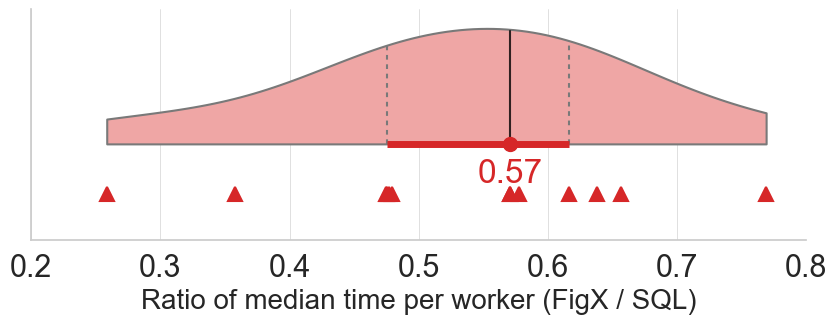

In [38]:
# Define figure settings
figwidth = 10
figheight = 3
xlab_size = 20
ylab_size = 20
figfont_size = 24

# Define consistent color maps
my_cmap_sns_dark = [(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]
my_cmap_sns_light = [(0.984313725490196, 0.6039215686274509, 0.6)]
my_cmap_dark = sns.color_palette(my_cmap_sns_dark, as_cmap=True)
my_cmap_light = sns.color_palette(my_cmap_sns_light, as_cmap=True)

# Create data frame for split violinplot
dfvp = pd.DataFrame()
dfvp["values"] = sample
dfvp["all"] = ""                                        # attribute that is shared by all entries
# print(dfvp)

# Create empty figure and plot the individual datapoints
fig, ax = plt.subplots(figsize=(figwidth,figheight))


# 1. Violinplot
axsns = sns.violinplot(x='values', y='all',    # y='all' just need to group both types together
                       data=dfvp,
                       hue = True, hue_order = [False, True],
                       split = True, inner = 'quartile',
                       cut=0,                  # 0 means ending sharp at end points
                       width=.6, scale = 'width',
                       # dodge = False,        # When using ``hue`` nesting, setting this to ``True`` will separate the strips for different hue levels along the categorical axis.
                       orient = 'h',
                       color=my_cmap_light[0])

# change the medium default linke to full
for l in axsns.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(1.5)
    l.set_color('black')
    l.set_alpha(0.8)
# for i in [0, 2]:         # remove the 25% and 75% quartiles
#     l = axsns.lines[i]
#     l.set_linestyle('-')
#     l.set_linewidth(0)
#     l.set_color('red')
#     l.set_alpha(0.8)


# 2. Plot individual points
y_tilt = -0.13                                   # Set some delta for the points below the violinplot
y_base = np.zeros(len(data_ratio)) + y_tilt     # base vector to which to broadcast y-tilt values

ax.plot(data_ratio, y_base,
        # 'o',
        '^',
        alpha=1,
        zorder=20,      # higher means more visible
        markersize=10,
        markeredgewidth=1.5,
        # markerfacecolor='none',
        markerfacecolor=my_cmap_dark[0],
        markeredgecolor=my_cmap_dark[0],
        )


# 3. CI Errorbars & show numbers
axeb = plt.errorbar(median_ratio, 0, xerr=np.array([[ci_ratio_delta[0], ci_ratio_delta[1]]]).T,
                    fmt='o',
                    markersize=10, alpha=1,
                    # lw = 3,
                    lw = 5,
                    zorder=100,      # higher means more visible
                    capsize = 10,
                    # capthick = 4,
                    capthick = 0,
                    # color = 'black',
                    color = my_cmap_dark[0],
                    )

med = np.median(sample)
# ax.text(med, 0.32, f'{100*med:.1f}%', horizontalalignment='center', color='black', fontsize=20)
# ax.text(med, 0.32, f'{med:.2f}', horizontalalignment='center', color='black', fontsize=20)
ax.text(med, -0.1, f'{med:.2f}', horizontalalignment='center',
        # color='black',
        color = my_cmap_dark[0],
        fontsize=figfont_size)
# ax.text(ci_ratio.low, 0.04, f'{100*ci_ratio.low:.1f}%', horizontalalignment='center', color='black', fontsize=20)
# ax.text(ci_ratio.high, 0.04, f'{100*ci_ratio.high:.1f}%', horizontalalignment='center', color='black', fontsize=20)


# Additional settings
# ax.set_ylim(-0.2, 0.4)
ax.set_ylim(-0.25, 0.35)
ax.set_ylabel(None)         # remove the 'all'
ax.set_xlim(0.2, 0.8)
# ax.set_xlabel('Ratio of median time per worker (RD / SQL)', size = xlab_size)
ax.set_xlabel('Ratio of median time per worker (FigX / SQL)', size = xlab_size)
sns.despine()               # remove bounding box
plt.grid(axis = 'x', linewidth = 0.5, color = 'lightgray')
ax.legend_.remove()

import matplotlib.ticker as mtick
# ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))           # show in percentage

if savefig:
    plt.savefig(fig_dir + "/q1_figure2.pdf", bbox_inches='tight')
    plt.savefig(fig_dir + "/q1_figure2.svg", bbox_inches='tight')

# Question 2

In [32]:
# Create df6, df7

df = df_anonymized_data[['worker_id', 'question', 'time', 'mode']]

df['H1'] = np.where(df['question'].between(1, 16, inclusive='both'), 'H1', '')          # TODO: creates warning but works for now
df['H2'] = np.where(df['question'].between(17, 32, inclusive='both'), 'H2', '')         # TODO: creates warning but works for now

df1 = df[['worker_id','question','time','mode','H1']].rename(columns={'H1': 'section'}) # Two sections: 1st half (H1) and 2nd half (H2)
df2 = df[['worker_id','question','time','mode','H2']].rename(columns={'H2': 'section'})
df4 = pd.concat([df1, df2])
df4 = df4.loc[df4['section'] != '']
df4 = df4.reset_index(inplace=False, drop=True)
# display(df4)

df5 = df4.groupby(['worker_id', 'mode', 'section']).time.agg(['median'])                # for each worker, calculate median for both modes and section
df5.reset_index(inplace=True)
# display(df5)

# pivot to have one row per worker
df6 = pd.pivot_table(df5, values=['median'], index=['worker_id'], columns=['mode', 'section'])
df6=df6.droplevel(0, axis=1)

# relative improvements per user
df6['RD', 'ratio'] = df6['RD', 'H2'] / df6['RD', 'H1']
df6['SQL', 'ratio'] = df6['SQL', 'H2'] / df6['SQL', 'H1']
display(df6)

# Median of median task time for each mode and section
modes = ['RD', 'SQL']
sections = ['H1', 'H2', 'ratio']
median_time = {}
ci = {}
ci_delta = {}
for mode in modes:
    for section in sections:
        column = (mode, section)
        median_time[column] = np.median(df6[column])
        ci[column] = scipybootstrap((df6[column],), statistic=np.median,
                                    n_resamples=BOOTSTRAPSAMPLES,
                                    confidence_level=BOOTSTRAPCONFIDENCE,
                                    method='percentile',
                                    axis=0).confidence_interval        #convert array to sequence
        ci_delta[column] = [median_time[column] - ci[column].low, ci[column].high - median_time[column]]

        print(f'{mode}, {section}: {median_time[column]:.3f}, 95% CI [{ci[column].low:.3f}, {ci[column].high:.3f}]')

# uses df5 to make df7 (used for later plot)
modes = ['SQL', 'RD']
sections = ['H1', 'H2']
df7 = df5.loc[df5['section'].isin(sections)]
# display(df7)

/var/folders/64/ybd4wh654nj2gk0nptgtchqw0000gn/T/ipykernel_68195/2260642199.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['H1'] = np.where(df['question'].between(1, 16, inclusive='both'), 'H1', '')          # TODO: creates warning but works for now
/var/folders/64/ybd4wh654nj2gk0nptgtchqw0000gn/T/ipykernel_68195/2260642199.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['H2'] = np.where(df['question'].between(17, 32, inclusive='both'), 'H2', '')         # TODO: creates warning but works for 

mode          RD          SQL           RD   SQL
section       H1    H2     H1     H2 ratio ratio
worker_id                                       
0          4.574 4.231 12.054  8.439 0.925 0.700
1          5.003 3.241  6.827  4.050 0.648 0.593
2         11.905 9.146 25.600 17.076 0.768 0.667
3          8.966 4.619 25.892 11.245 0.515 0.434
4         16.489 6.985 28.895 11.956 0.424 0.414
5         12.813 5.413 73.099 10.333 0.423 0.141
6         12.675 4.580  8.597  5.418 0.361 0.630
7          8.829 7.042 21.371 11.062 0.798 0.518
8          6.793 3.695 12.188  6.908 0.544 0.567
9         17.650 4.139 11.913 13.957 0.235 1.172
10         3.557 2.864  6.681  6.902 0.805 1.033
11        11.439 9.291 25.381 21.604 0.812 0.851
12         7.022 3.512 14.547  6.168 0.500 0.424

RD, H1: 8.966, 95% CI [6.793, 12.675]
RD, H2: 4.580, 95% CI [3.695, 6.985]
RD, ratio: 0.544, 95% CI [0.424, 0.798]
SQL, H1: 14.547, 95% CI [11.913, 25.600]
SQL, H2: 10.333, 95% CI [6.902, 11.956]
SQL, ratio: 0.593, 95% CI [0.434, 0.700]


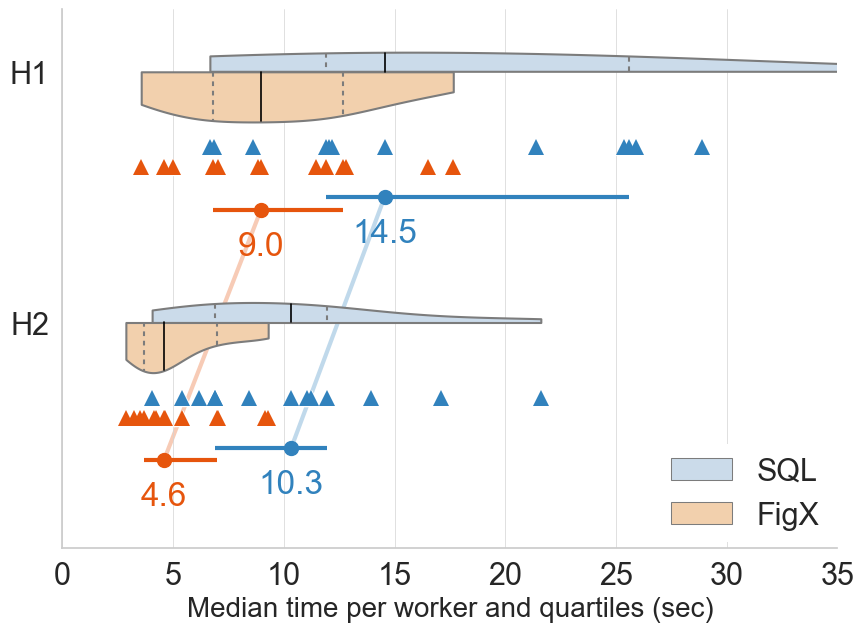

In [35]:
# Plot (uses df6, df7)

# Define pre-settings
figwidth = 10
figheight = 7
xlab_size = 20
ylab_size = 20
figfont_size = 24

# Define consistent color maps
my_cmap_sns_light = [(0.7764705882352941, 0.8588235294117647, 0.9372549019607843), (0.9921568627450981, 0.8156862745098039, 0.6352941176470588)]        # light orange, light blue
my_cmap_sns_dark = [(0.19215686274509805, 0.5098039215686274, 0.7411764705882353), (0.9019607843137255, 0.3333333333333333, 0.050980392156862744)]      # dark orange, dark blue
my_cmap_dark = sns.color_palette(my_cmap_sns_dark, as_cmap=True)
my_cmap_light = sns.color_palette(my_cmap_sns_light, as_cmap=True)


# Create empty figure and plot the individual datapoints
fig, ax = plt.subplots(figsize=(figwidth,figheight))


# 1. Violinplots
axsns = sns.violinplot(x='median', y='section', data=df7,
                       hue='mode',
                       hue_order=['SQL', 'RD'],
                       split=True,   # half violinplots https://stackoverflow.com/questions/53872439/half-not-split-violin-plots-in-seaborn
                       inner='quartile',
                       cut=0,               # 0 means ending sharp at end points
                       width=.4,
                       orient = 'h',
                       zorder=20,
                       palette = my_cmap_light,)

# change the medium default line to full (https://stackoverflow.com/questions/60638344/quartiles-line-properties-in-seaborn-violinplot)
for l in axsns.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(1.2)
    l.set_color('black')
    # l.set_alpha(0.8)

# for i in [0, 2, 3, 5]:         # remove the 25% and 75% quartiles
#     l = axsns.lines[i]
#     l.set_linestyle('-')
#     l.set_linewidth(0)
#     l.set_color('red')
#     l.set_alpha(0.8)


# 2. Plot individual points
y_base = np.zeros(df6.values.shape[0])  # base vector to which to broadcast y-tilt values
y_tilt_mode = [0.3, 0.38]
y_tilt_section = [0, 1]
for i, mode in enumerate(modes):
    for j, section in enumerate(sections):
        column = (mode, section)
        ax.plot(df6[column],
                y_base + y_tilt_mode[i] + y_tilt_section[j],
                # 'o',
                # '|',
                '^',
                alpha=1,
                zorder=20,      # higher means more visible
                markersize=11,
                markeredgewidth=0,
                # markerfacecolor='none',
                markerfacecolor=my_cmap_sns_dark[i],
                markeredgecolor=my_cmap_sns_dark[i],)
        ax.plot(df6[column],          # white background
                y_base + y_tilt_mode[i] + y_tilt_section[j],
                # 'o',
                # '|',
                '^',
                markersize=11,
                markeredgewidth=1,
                markerfacecolor='white',
                color ='white',
                linewidth = None,
                zorder=1,)


# # 3. Plot lines connecting points
# for idx in df6.index:
#     for i, mode in enumerate(modes):
#         for j in range(len(sections)-1):
#             start = (mode, sections[j])
#             end = (mode, sections[j+1])
#             ax.plot(df6.loc[idx, [start, end]],
#                     [y_tilt_mode[i] + y_tilt_section[j], y_tilt_mode[i] + y_tilt_section[j+1]],
#                     color=my_cmap_sns_dark[i], linewidth=2, linestyle='-', alpha=.2, zorder=0)


# 4. CI Errorbars & numbers
y_tilt_mode = [0.5, 0.55]
# y_tilt_section_bar = [0.23, 0.8]
# y_tilt_section_number = [0.19, 0.89]
for i, mode in enumerate(modes):
    for j, section in enumerate(sections):
        column = (mode, section)
        plt.errorbar(median_time[column], y_tilt_mode[i]+y_tilt_section[j],
                     xerr=np.array([[ci_delta[column][0] ,ci_delta[column][1]]]).T,
                     fmt='o', markersize=10,
                     lw = 3, alpha=1,
                     zorder=100,        # higher means more visible
                     #             capsize = 10, capthick = 4,
                     color = my_cmap_sns_dark[i]    # 'black'
                     )
        ax.text(median_time[column], y_tilt_mode[i]+y_tilt_section[j] + 0.18, f'{median_time[column]:.1f}',
                horizontalalignment='center', color = my_cmap_sns_dark[i],
                fontsize=figfont_size)


# 5. Plot red line connecting medians
for i, mode in enumerate(modes):
    ax.plot([median_time[(mode, 'H1')], median_time[(mode, 'H2')]],
            [y_tilt_mode[i]+y_tilt_section[0], y_tilt_mode[i]+y_tilt_section[1]],
            color=my_cmap_sns_dark[i], linewidth = 3, linestyle ='-',
            alpha=.3,
            zorder=0)


# #Additional settings
ax.set_xlabel('Median time per worker and quartiles (sec)', size = xlab_size)
ax.set_ylabel(None)
ax.set_xlim(0, 35)
ax.set_ylim(1.9, -0.25)
leg = plt. legend(loc='lower right',
                  borderaxespad= 0.2,
                  frameon = True,)
leg.get_frame().set_alpha(1)
leg.get_frame().set_linewidth(0.0)
for text, text2 in zip(leg.get_texts(), ['SQL', 'FigX']):
    text.set_text(text2)

plt.grid(axis = 'x', linewidth = 0.5, color = 'lightgray')
sns.despine()               # remove bounding box

if savefig:
    plt.savefig(fig_dir + "/q2_figure.pdf", bbox_inches='tight')
    plt.savefig(fig_dir + "/q2_figure.svg", bbox_inches='tight')

# Question 3: four patterns

(1) calculate the median time per pattern (4) across the two modes (2). Thus 8 values.
(2) show repeated measure violin plot figure

In [27]:
# Create df8

df = df_anonymized_data[['worker_id', 'pattern', 'time', 'mode']]
# print(df)

df8 = df.groupby(['worker_id', 'mode', 'pattern']).time.agg(['median'])         # for each worker, calculate median for both modes
df8.reset_index(inplace=True)
display(df8)

# Pivot to have one row per worker
df9 = pd.pivot_table(df8, values=['median'], index=['worker_id'], columns=['mode', 'pattern'])
df9=df9.droplevel(0, axis=1)
display(df9)

# Median of median task time for each mode and section (for error plots)
modes = ['RD', 'SQL']
patterns = [1, 2, 3, 4]
median_time = {}
ci = {}
ci_delta = {}
for mode in modes:
    for pattern in patterns:
        column = (mode, pattern)
        median_time[column] = np.median(df9[column])
        ci[column] = scipybootstrap((df9[column],), statistic=np.median,
                                    n_resamples=BOOTSTRAPSAMPLES,
                                    confidence_level=BOOTSTRAPCONFIDENCE,
                                    method='percentile',
                                    axis=0).confidence_interval        #convert array to sequence
        ci_delta[column] = [median_time[column] - ci[column].low, ci[column].high - median_time[column]]
# print(median_time)
# print(ci)
# print(ci_delta)

,worker_id,mode,pattern,median
0,0,RD,1,3.235
1,0,RD,2,4.542
2,0,RD,3,6.337
3,0,RD,4,4.062
4,0,SQL,1,9.212
...,...,...,...,...
99,12,RD,4,3.728
100,12,SQL,1,7.357
101,12,SQL,2,9.568
102,12,SQL,3,10.256


mode         RD                         SQL                     
pattern       1      2      3      4      1      2      3      4
worker_id                                                       
0         3.235  4.542  6.337  4.062  9.212  9.437 14.511  7.667
1         3.590  3.881  5.722  3.229  3.820  6.677  6.269 10.065
2         5.568 13.332 12.968 16.290  8.244 20.711 31.367 22.358
3         5.699  9.593  8.220  9.334  7.720 18.619 23.386 17.523
4         5.487 13.705 24.541 11.132 10.759 13.135 21.520 10.039
5         3.702  8.167 32.527  5.445 25.289 87.439 11.405 36.320
6         3.391  4.580 19.679  3.914  5.270  9.737 23.405  3.905
7         5.366 11.875  8.439 12.018 18.546 17.215 13.441  8.468
8         4.659 13.281  8.259  3.921  8.605 10.188 13.319 11.075
9         3.447 14.052 14.971  3.616  6.475 22.712 14.451  6.975
10        2.444  6.462  3.482  2.925  3.433  7.648 10.075  6.526
11        5.579 15.940 47.182 12.917 18.217 26.620 33.282 20.020
12        3.659  5.232 11.367  3.728  7.357  9.568 10.256  6.075

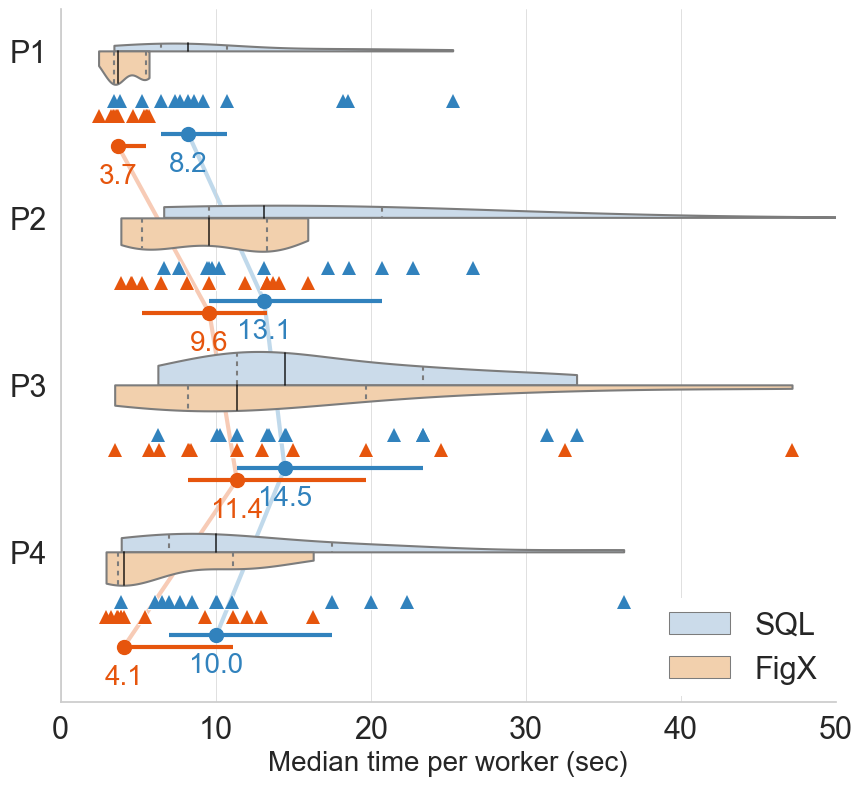

In [31]:
# needs df8 for violin, df9 for points, dictionaries (median_time, ci, ci_delta) for error plots, df6 for individual points

modes = ['SQL', 'RD']
patterns = [1, 2, 3, 4]
y_tilt_section = [0, 1, 2, 3]

# Define pre-settings
figwidth = 10
figheight = 9
xlab_size = 20
ylab_size = 20
figfont_size = 20

# Define consistent color maps
my_cmap_sns_light = [(0.7764705882352941, 0.8588235294117647, 0.9372549019607843), (0.9921568627450981, 0.8156862745098039, 0.6352941176470588)]        # light orange, light blue
my_cmap_sns_dark = [(0.19215686274509805, 0.5098039215686274, 0.7411764705882353), (0.9019607843137255, 0.3333333333333333, 0.050980392156862744)]      # dark orange, dark blue
my_cmap_dark = sns.color_palette(my_cmap_sns_dark, as_cmap=True)
my_cmap_light = sns.color_palette(my_cmap_sns_light, as_cmap=True)

# Create empty figure and plot the individual datapoints
fig, ax = plt.subplots(figsize=(figwidth,figheight))


# 1. Violinplots
axsns = sns.violinplot(x='median', y='pattern', data=df8,
                       hue='mode',
                       hue_order=['SQL', 'RD'],
                       split=True,   # half violinplots https://stackoverflow.com/questions/53872439/half-not-split-violin-plots-in-seaborn
                       inner='quartile',
                       cut=0,               # 0 means ending sharp at end points
                       width=.4,
                       orient = 'h',
                       zorder=20,
                       palette = my_cmap_light,)

# change the medium default line to full (https://stackoverflow.com/questions/60638344/quartiles-line-properties-in-seaborn-violinplot)
for l in axsns.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(1.2)
    l.set_color('black')
    l.set_alpha(0.8)
# for i in [0, 2, 3, 5]:         # remove the 25% and 75% quartiles
#     l = axsns.lines[i]
#     l.set_linestyle('-')
#     l.set_linewidth(0)
#     l.set_color('red')
#     l.set_alpha(0.8)


# 2. Plot individual points
y_base = np.zeros(df6.values.shape[0])  # base vector to which to broadcast y-tilt values
y_tilt_mode = [0.3, 0.39]
for i, mode in enumerate(modes):
    for j, pattern in enumerate(patterns):
        column = (mode, pattern)
        ax.plot(df9[column],
                y_base + y_tilt_mode[i] + y_tilt_section[j],
                '^',
                alpha=1,
                zorder=20,      # higher means more visible
                markersize=10,
                markeredgewidth=0,
                # markerfacecolor='none',
                markerfacecolor=my_cmap_sns_dark[i],
                markeredgecolor=my_cmap_sns_dark[i],)
        ax.plot(df9[column],    # white background behind the markers, but in front of the connecting lines
                y_base + y_tilt_mode[i] + y_tilt_section[j],
                '^',
                markersize=10,
                markeredgewidth=1,
                markerfacecolor='white',
                color ='white',
                linewidth = None,
                zorder=1,)


# # 3. Plot lines connecting individual points
# for idx in df9.index:
#     for i, mode in enumerate(modes):
#         for j in range(len(patterns)-1):
#             start = (mode, patterns[j])
#             end = (mode, patterns[j+1])
#             ax.plot(df9.loc[idx, [start, end]],
#                     [y_tilt_mode[i] + y_tilt_section[j], y_tilt_mode[i] + y_tilt_section[j+1]],
#                     color =my_cmap_sns_dark[i], linewidth = 2, linestyle ='-', alpha = .2, zorder=0)


# 4. CI Errorbars & numbers
y_tilt_mode = [0.5, 0.57]
for i, mode in enumerate(modes):
    for j, section in enumerate(patterns):
        column = (mode, section)
        plt.errorbar(median_time[column],
                     y_tilt_mode[i]+y_tilt_section[j],
                     xerr=np.array([[ci_delta[column][0] ,ci_delta[column][1]]]).T,
                     fmt='o', markersize=10,
                     lw = 3, alpha=1,
                     zorder=100,        # higher means more visible
                     color = my_cmap_sns_dark[i])    # 'black'
        ax.text(median_time[column], y_tilt_mode[i]+y_tilt_section[j] + 0.22, f'{median_time[column]:.1f}',
                horizontalalignment='center', color = my_cmap_sns_dark[i],
                fontsize=figfont_size)


# 5. Plot red line connecting medians
for i, mode in enumerate(modes):
    for j in range(len(patterns)-1):
        start = (mode, patterns[j])
        end = (mode, patterns[j+1])
        ax.plot([median_time[start], median_time[end], ],
                [y_tilt_mode[i] + y_tilt_section[j], y_tilt_mode[i] + y_tilt_section[j+1]],
                color =my_cmap_sns_dark[i], linewidth = 3, linestyle ='-', alpha = .3, zorder=0)



# # #Additional settings
ax.set_xlabel('Median time per worker (sec)', size = xlab_size)
ax.set_ylabel(None)
ax.set_yticklabels(['P1', 'P2', 'P3', 'P4'])
ax.set_xlim(0, 50)
ax.set_ylim(3.9, -0.25)
leg = plt.legend(loc='lower right',
                 borderaxespad= 0.2,
                 frameon = True,)
leg.get_frame().set_alpha(1)
leg.get_frame().set_linewidth(0.0)

for text, text2 in zip(leg.get_texts(), ['SQL', 'FigX']):
    text.set_text(text2)

plt.grid(axis = 'x', linewidth = 0.5, color = 'lightgray')
sns.despine()               # remove bounding box

if savefig:
    plt.savefig(fig_dir + "/q3_figure.pdf", bbox_inches='tight')
    plt.savefig(fig_dir + "/q3_figure.svg", bbox_inches='tight')

# Question 4: Correctness

(1) take mean correct over all questions and all users answered in SQL or RD (32/2*13) and the difference in correctness score
(2) calculate 95% CI for each

In [39]:
# dfq4a: Create two columns mode and mean, with 2 rows per worker
dfq4a = df_anonymized_data.groupby(['worker_id', 'mode']).correct.agg(['mean'])
dfq4a.reset_index(inplace=True)
# display(dfq4a)

# dfq4b: Pivot to have one row per worker
dfq4b = pd.pivot_table(dfq4a, values=['mean'], index=['worker_id'], columns=['mode'])
dfq4b=dfq4b.droplevel(0, axis=1)
dfq4b['diff'] = dfq4b['RD'] - dfq4b['SQL']
print("dfq4b:\n")
display(dfq4b)

# Calculate fraction of those better in either mode
num_SQLbetter = np.where(dfq4b['SQL'] > dfq4b['RD'], 1, 0).sum()
num_RDbetter = np.where(dfq4b['SQL'] < dfq4b['RD'], 1, 0).sum()
num_workers =len(dfq4b)
print(f'{num_SQLbetter}/{num_workers} ({num_SQLbetter/num_workers:.3f}) better with SQL.')
print(f'{num_RDbetter}/{num_workers} ({num_RDbetter/num_workers:.3f}) better with RD.')
print(f'{num_workers-num_RDbetter-num_RDbetter}/{num_workers} ({(num_workers-num_RDbetter-num_RDbetter)/num_workers:.3f}) equally good.')

# Mean of mean correctness for each mode Plus 95% CI
modes_diff = ['RD', 'SQL', 'diff']
mean_correct = {}
ci = {}
ci_delta = {}
for mode in modes_diff:
    mean_correct[mode] = np.mean(dfq4b[mode])
    ci[mode] = scipybootstrap((dfq4b[mode],), statistic=np.mean, n_resamples=BOOTSTRAPSAMPLES, confidence_level=BOOTSTRAPCONFIDENCE, method='percentile', axis=0).confidence_interval        #convert array to sequence
    ci_delta[mode] = [mean_correct[mode] - ci[mode].low, ci[mode].high - mean_correct[mode]]

print(f"mean RD correct = {mean_correct['RD']:.3f}, 95% CI [{ci['RD'].low:.3f}, {ci['RD'].high:.3f}]")
print(f"mean SQL correct = {mean_correct['SQL']:.3f}, 95% CI [{ci['SQL'].low:.3f}, {ci['SQL'].high:.3f}]")
print(f"mean difference in correctness = {mean_correct['diff']:.3f}, 95% CI [{ci['diff'].low:.3f}, {ci['diff'].high:.3f}]")

dfq4b:



mode,RD,SQL,diff
worker_id,,,
0,0.938,0.938,0.000
1,1.000,1.000,0.000
2,0.938,0.750,0.188
3,0.938,0.938,0.000
4,0.938,0.938,0.000
5,0.938,0.938,0.000
6,1.000,1.000,0.000
7,1.000,0.938,0.062
8,0.875,0.938,-0.062


3/13 (0.231) better with SQL.
4/13 (0.308) better with RD.
5/13 (0.385) equally good.
mean RD correct = 0.942, 95% CI [0.923, 0.962]
mean SQL correct = 0.928, 95% CI [0.889, 0.957]
mean difference in correctness = 0.014, 95% CI [-0.019, 0.053]


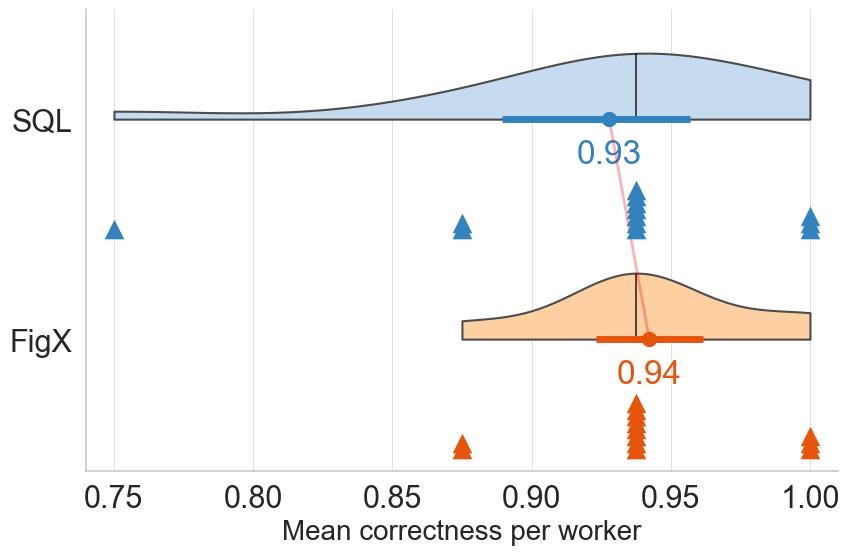

In [71]:
# Removing 'diff' from variables
dfq4c=dfq4b.copy()
dfq4c.drop('diff', inplace=True, axis=1)
modes = ['RD', 'SQL']

# Define pre-settings
figwidth = 9.7
figheight = 6
xlab_size = 20
ylab_size = 20
figfont_size = 24

# Define consistent color maps
my_cmap_sns_light = [(0.9921568627450981, 0.8156862745098039, 0.6352941176470588), (0.7764705882352941, 0.8588235294117647, 0.9372549019607843)]        # light blue, light orange
my_cmap_sns_dark = [(0.9019607843137255, 0.3333333333333333, 0.050980392156862744), (0.19215686274509805, 0.5098039215686274, 0.7411764705882353)]      # dark blue, dark orange
my_cmap_dark = sns.color_palette(my_cmap_sns_dark, as_cmap=True)
my_cmap_light = sns.color_palette(my_cmap_sns_light, as_cmap=True)

# Create empty figure and plot the individual datapoints
fig, ax = plt.subplots(figsize=(figwidth,figheight))

# 1. Violinplots
axsns = sns.violinplot(x='mean', y='mode', data=dfq4a,
                       hue=True, hue_order=[False, True], split=True,   # half violinplots https://stackoverflow.com/questions/53872439/half-not-split-violin-plots-in-seaborn
                       inner='quartile',
                       cut=0,               # 0 means ending sharp at end points
                       width=.6,
                       orient = 'h',
                       zorder=20,)

# change the medium default line to full (https://stackoverflow.com/questions/60638344/quartiles-line-properties-in-seaborn-violinplot)
for l in axsns.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(1.2)
    l.set_color('black')
    l.set_alpha(0.8)
for i in [0, 2, 3, 5]:         # remove the 25% and 75% quartiles
    l = axsns.lines[i]
    l.set_linestyle('-')
    l.set_linewidth(0)
    l.set_color('red')
    l.set_alpha(0.8)

# Apply colorscheme to violinplots https://stackoverflow.com/questions/70442958/seaborn-how-to-apply-custom-color-to-each-seaborn-violinplot
from matplotlib.collections import PolyCollection
for ind, violin in enumerate(axsns.findobj(PolyCollection)):
    violin.set_facecolor(my_cmap_light[ind])
# plt.setp(ax.collections, alpha=.999)  # semi-transparent (https://stackoverflow.com/questions/62597959/seaborn-violinplot-transparency)


# 2. Plot individual points [new dot plot]
# Set the amount of jitter and create a dataframe containing the jittered x-axis values [kept for legacy reasons, could be simplified with new dot plot
jitter = 0.0     # 0.1
y_tilt = -0.5

# np.random.seed(3)
df_jitter = pd.DataFrame(
    np.random.uniform(low=y_tilt, high=y_tilt + jitter, size=dfq4c.values.shape),
    columns=dfq4c.columns)
df_jitter += np.arange(len(dfq4c.columns)) #Add to dataframe a number based on the length on the columns. Otherwise all datapoints would be at the same x-axis location.

# for i, col in enumerate(dfq4c):
#     ax.plot(dfq4c[col], df_jitter[col],
#             '^',
#             alpha=1,
#             zorder=20,      # higher means more visible
#             markersize=10,
#             markeredgewidth=1.5,
#             # markerfacecolor='none',
#             markerfacecolor=my_cmap_dark[i],
#             markeredgecolor=my_cmap_dark[i],)


# sns.swarmplot(x = "species", y = "petal_length", data = df)
def dotplot(input_x, y0, delta, **args):
    unique_values, counts = np.unique(input_x, return_counts=True)  # Count how many times does each value occur

    # Convert 1D input into 2D array
    scatter_x = [] # x values
    scatter_y = [] # corresponding y values
    for idx, value in enumerate(unique_values):
        for counter in range(0, counts[idx]):
            scatter_x.append(value)
            scatter_y.append(y0+counter*delta)
    plt.scatter(scatter_x, scatter_y, **args)

for i, col in enumerate(dfq4c):
    dotplot(input_x=dfq4c[col], y0=df_jitter[col][0], delta=0.03,
            marker='^',
            alpha=1,
            zorder=20,      # higher means more visible
            color=my_cmap_dark[i],
            s=200,
            linewidth=0,)


# 4. Plot red line connecting means
ax.plot(np.mean(dfq4c, axis=0), [0, 1], color ='red', linewidth = 2, linestyle ='-',
        alpha = .3,
        zorder=4,
        )

# 5. CI Errorbars
for i, mode in enumerate(modes):
    plt.errorbar(mean_correct[mode], i, xerr=np.array([[ci_delta[mode][0], ci_delta[mode][1]]]).T,
                 fmt='o', markersize=10,
                 lw = 5, alpha=1,
                 zorder=100,        # higher means more visible
                 capsize = 10,
                 # capthick = 4,
                 capthick = 0,
                 # color = 'black',
                 color=my_cmap_dark[i],
                 )   # my_cmap[1])

    # ax.text(median_time[column], y_tilt_mode[i]+y_tilt_section[j] + 0.18, f'{median_time[column]:.1f}',
    #         horizontalalignment='center', color = my_cmap_sns_dark[i], fontsize=20)
    ax.text(mean_correct[mode],
            i-0.2,
            f'{mean_correct[mode]:.2f}', horizontalalignment='center',
            # color='black',
            color=my_cmap_dark[i],
            fontsize=figfont_size)
    # ax.text(ci[mode].low, i+0.1, f'{ci[mode].low:.2f}', horizontalalignment='center', color='black', fontsize=20)
    # ax.text(ci[mode].high, i+0.1, f'{ci[mode].high:.2f}', horizontalalignment='center', color='black', fontsize=20)


#Additional settings
# ax.set_yticklabels(modes, size= ylab_size)
# ax.set_xlim(0.7499, 1.0003)
ax.set_xlim(0.74, 1.01)
ax.set_ylim(-0.6, 1.5)
ax.set_xlabel('Mean correctness per worker', size = xlab_size)
ax.set_ylabel(None)
ax.set_yticklabels(['FigX', 'SQL'])
ax.legend_.remove()
plt.grid(axis = 'x', linewidth = 0.5, color = 'lightgray')
sns.despine()               # remove bounding box

if savefig:
    plt.savefig(fig_dir + "/q4_figure.pdf", bbox_inches='tight')
    plt.savefig(fig_dir + "/q4_figure.svg", bbox_inches='tight')